In [15]:
from data_preparation import *
from custom_layers import *
from graph_reduce_cell import GraphReduceCell
import networkx as nx
import time
from tensorflow.keras.layers import TimeDistributed, Concatenate, Dense
from tensorflow.keras import Model

# get_subgraphs test

In [2]:
def prepare_matrices():
    adj_matrix = np.array([[0,1,0,0],
                           [1,0,1,1],
                           [0,1,0,1],
                           [0,1,1,0]])


    no_bond = np.zeros((4,4,3))
    no_bond[:,:,0]=1

    fosforowe = np.zeros((4,4,3))
    fosforowe[:,:,1]=1

    wodorowe = np.zeros((4,4,3))
    wodorowe[:,:,2]=1

    broadcasted_adj_matrix = np.repeat(adj_matrix[:, :, np.newaxis], 3, axis=2)

    x = np.where(broadcasted_adj_matrix, fosforowe, no_bond)

    wodorowe_chooser = np.array([[0,0,0,0],
                                 [0,0,0,1],
                                 [0,0,0,0],
                                 [0,1,0,0]])
    broadcasted_wodorowe_chooser = np.repeat(wodorowe_chooser[:, :, np.newaxis], 3, axis=2)

    edges_features_matrix = np.where(broadcasted_wodorowe_chooser, wodorowe, x)
    
    features_seq = (np.random.rand(4,14) < 0.5).astype(np.float32)
    
    return features_seq, adj_matrix, edges_features_matrix

In [3]:
features_seq, adj_matrix, edges_features_matrix = prepare_matrices()

In [4]:
features_seq.shape

(4, 14)

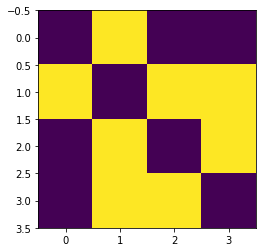

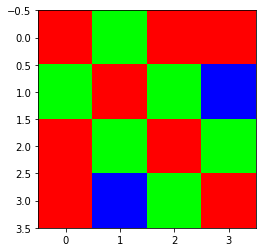

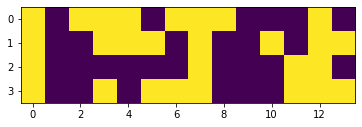

In [5]:
plt.figure()
plt.imshow(adj_matrix)
plt.figure()
plt.imshow(edges_features_matrix)
plt.figure()
plt.imshow(features_seq)

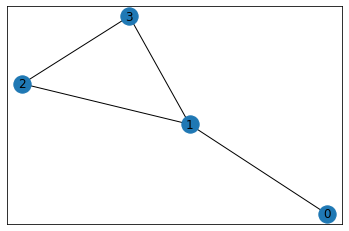

In [6]:
G = nx.from_numpy_matrix(adj_matrix)
nx.draw_networkx(G)

In [7]:
subgraphs_features_sequences, subgraphs_adjacency_matrices, subgraphs_edges_features_matrices = get_subgraphs(features_seq, adj_matrix, edges_features_matrix, 3)

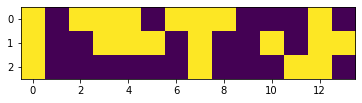

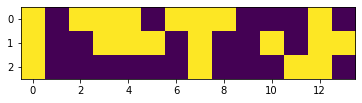

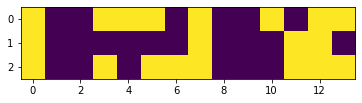

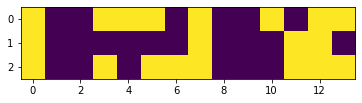

In [8]:
for seq in subgraphs_features_sequences:
    plt.figure()
    plt.imshow(seq)

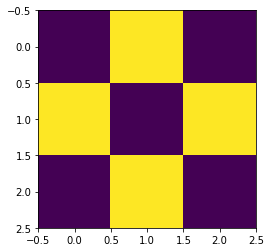

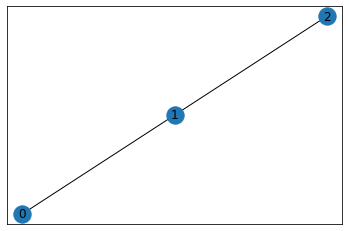

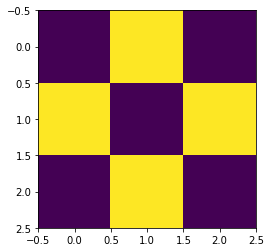

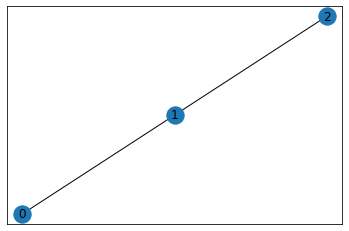

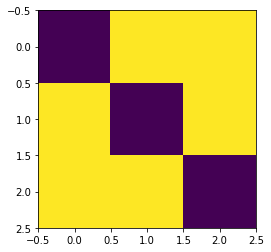

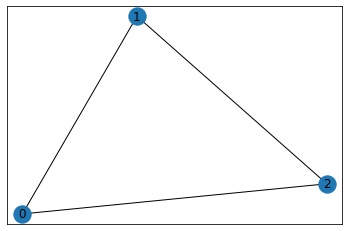

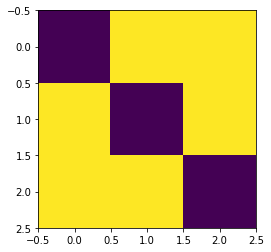

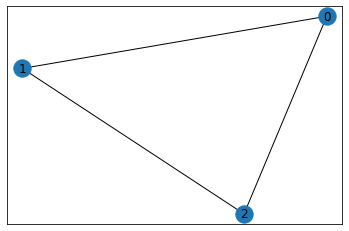

In [9]:
for matrix in subgraphs_adjacency_matrices:
    plt.figure()
    plt.imshow(matrix)
    plt.figure()
    G = nx.from_numpy_matrix(matrix)
    nx.draw_networkx(G)

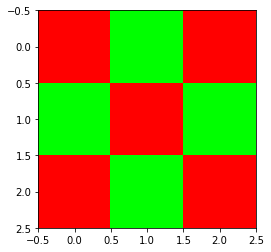

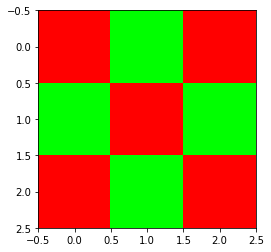

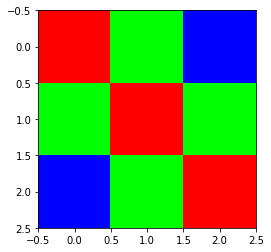

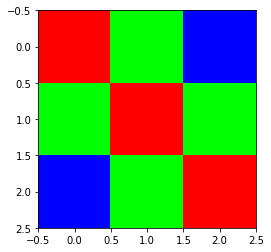

In [10]:
for matrix in subgraphs_edges_features_matrices:
    plt.figure()
    plt.imshow(matrix)

# SubgraphingLayer test

In [2]:
def plot_inputs_batch(prepared_data):
    plot_size = 3
    examples_number = prepared_data[0].shape[0]
    features_number = 3
    fig, axes = plt.subplots(examples_number, features_number, figsize=(features_number * plot_size, examples_number * plot_size))

    for i in range(examples_number):
        for j in range(features_number):
            axes[i,j].imshow(prepared_data[j][i])

    plt.show(fig)

In [37]:
BATCH_SIZE = 64
SEQ_LEN = 68
STACKED_FEATURES_SIZE = 14
EDGES_FEATURES_MATRIX_DEPTH = 3
NEIGHBOURHOOD_SIZE = 10
UNITS = 7

STACKED_LABELS_SIZE = 3

In [3]:
train_valid_ds, public_test_ds, private_test_ds = get_datasets()

In [4]:
exp_ds = train_valid_ds.take(BATCH_SIZE).batch(BATCH_SIZE)

In [5]:
data_batch = next(iter(exp_ds))
x, y = data_batch
inputs_batch = (x['stacked_scored_features'], x['adjacency_matrix'], x['edges_features_matrix'])

In [6]:
assert inputs_batch[0].shape == (BATCH_SIZE, SEQ_LEN, STACKED_FEATURES_SIZE)
assert inputs_batch[1].shape == (BATCH_SIZE, SEQ_LEN, SEQ_LEN)
assert inputs_batch[2].shape == (BATCH_SIZE, SEQ_LEN, SEQ_LEN, EDGES_FEATURES_MATRIX_DEPTH)

In [7]:
start = time.time()
graph_reduce_inputs_batch = SubgraphingLayer(10)(inputs_batch)
end = time.time()
print(end-start)

[None, None, 10, 14]
[None, None, 10, 10]
[None, None, 10, 10, 3]
subgraphed_features_batch.shape: (64, 68, 10, 14)
subgraphed_adj_matrices_batch.shape: (64, 68, 10, 10)
subgraphed_edges_features_matrices_batch.shape: (64, 68, 10, 10, 3)
subgraphed_features_batch.shape: (64, 68, 10, 14)
subgraphed_adj_matrices_batch.shape: (64, 68, 10, 10)
subgraphed_edges_features_matrices_batch.shape: (64, 68, 10, 10, 3)
0.7819023132324219


In [8]:
assert type(graph_reduce_inputs_batch) == tuple
assert len(graph_reduce_inputs_batch) == 3

assert graph_reduce_inputs_batch[0].shape == [BATCH_SIZE, SEQ_LEN, NEIGHBOURHOOD_SIZE, STACKED_FEATURES_SIZE]
assert graph_reduce_inputs_batch[1].shape == [BATCH_SIZE, SEQ_LEN, NEIGHBOURHOOD_SIZE, NEIGHBOURHOOD_SIZE]
assert graph_reduce_inputs_batch[2].shape == [BATCH_SIZE, SEQ_LEN, NEIGHBOURHOOD_SIZE, NEIGHBOURHOOD_SIZE, EDGES_FEATURES_MATRIX_DEPTH]

# Graph Reduce layer test

In [9]:
start = time.time()
reduced_sequence = tf.keras.layers.RNN(GraphReduceCell(UNITS), return_sequences=True)(graph_reduce_inputs_batch)
end = time.time()
print(end-start)

0.3706698417663574


In [10]:
assert reduced_sequence.shape == [BATCH_SIZE, SEQ_LEN, UNITS]

In [11]:
exp_ds

<BatchDataset shapes: ({sequence: (None, None, 4), structure: (None, None, 3), predicted_loop_type: (None, None, 7), adjacency_matrix: (None, None, None), edges_features_matrix: (None, None, None, 3), seq_scored: (None,), stacked_scored_features: (None, None, 14)}, {stacked_scored_labels: (None, 68, 3)}), types: ({sequence: tf.float32, structure: tf.float32, predicted_loop_type: tf.float32, adjacency_matrix: tf.float32, edges_features_matrix: tf.float32, seq_scored: tf.float32, stacked_scored_features: tf.float32}, {stacked_scored_labels: tf.float32})>

# Graph Reduce model test

In [10]:
# INPUTS
stacked_scored_features_input = Input(shape=(SEQ_LEN, STACKED_FEATURES_SIZE), name='stacked_scored_features')
adjacency_matrix_input = Input(shape=(SEQ_LEN, SEQ_LEN), name='adjacency_matrix')
edges_features_matrix_input = Input(shape=(SEQ_LEN, SEQ_LEN, EDGES_FEATURES_MATRIX_DEPTH), name='edges_features_matrix')

inputs = (stacked_scored_features_input, adjacency_matrix_input, edges_features_matrix_input)

x = SubgraphingLayer(NEIGHBOURHOOD_SIZE)(inputs)

x = tf.keras.layers.RNN(GraphReduceCell(UNITS), return_sequences=True)(x)

# OUTPUTS
reactivity_pred = TimeDistributed(Dense(1), name='reactivity')(x)
deg_Mg_pH10_pred = TimeDistributed(Dense(1), name='deg_Mg_pH10')(x)
deg_Mg_50C_pred = TimeDistributed(Dense(1), name='deg_Mg_50C')(x)

scored_outputs = [reactivity_pred, deg_Mg_pH10_pred, deg_Mg_50C_pred]
stacked_outputs = Concatenate(axis=2, name='stacked_outputs')(scored_outputs)

# TRAINING MODEL

model = Model(inputs=inputs, outputs={'stacked_scored_labels': stacked_outputs}, name='graph_reduce_model')

[None, None, 10, 14]
[None, None, 10, 10]
[None, None, 10, 10, 3]
subgraphed_features_batch.shape: <unknown>
subgraphed_adj_matrices_batch.shape: <unknown>
subgraphed_edges_features_matrices_batch.shape: <unknown>
subgraphed_features_batch.shape: (None, None, 10, 14)
subgraphed_adj_matrices_batch.shape: (None, None, 10, 10)
subgraphed_edges_features_matrices_batch.shape: (None, None, 10, 10, 3)


In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
stacked_scored_features (InputL [(None, 68, 14)]     0                                            
__________________________________________________________________________________________________
adjacency_matrix (InputLayer)   [(None, 68, 68)]     0                                            
__________________________________________________________________________________________________
edges_features_matrix (InputLay [(None, 68, 68, 3)]  0                                            
__________________________________________________________________________________________________
subgraphing_layer_1 (Subgraphin ((None, None, 10, 14 0           stacked_scored_features[0][0]    
                                                                 adjacency_matrix[0][0]       

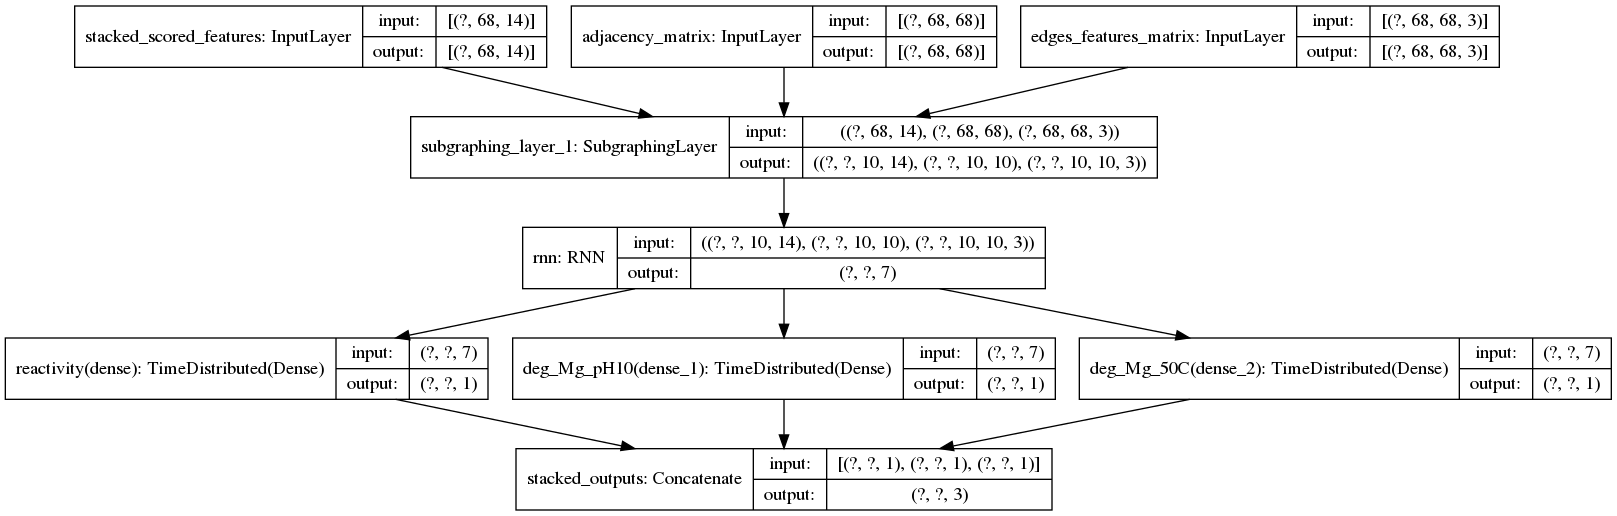

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [19]:
start = time.time()
predictions = model.predict(exp_ds)
end = time.time()
print(end-start)

1.4321043491363525


In [21]:
assert type(predictions) == dict

In [43]:
keys = list(predictions.keys())
assert len(keys) == 1
assert keys[0] == 'stacked_scored_labels'

In [44]:
assert list(predictions['stacked_scored_labels'].shape) == [BATCH_SIZE, SEQ_LEN, STACKED_LABELS_SIZE]